# Find circles

Finding circles is crucial in my previous project of studying bacterial suspensions confined in droplets, as well as for my current project about condensation. I've been using the HoughCircle function in OpenCV to detect circles, but the results are always not very satisfactory. Even more annoying, Matlab has a function `imfindcircles`, always gives better results than `HoughCircle`, making a Python user very frustrated. Is there an equivalence in Python that can find circle with comparable performance as `imfindcircle` in Matlab?

After a brief search, I conclude that such equivalence does not exist. I start to read the documentation of the Matlab function, and notice the paper based on which the Matlab function is built. The paper is [Atherton and Kerbyson 1999](https://www.sciencedirect.com/science/article/pii/S0262885698001607).

The key idea of this is to use the edge orientation information, besides the edge location information, to calculate the accumulator for the circle detection. 

I haven't understood the full content of the paper yet, but with the key idea, I'm able to build a circle detection algorithm that improves the performance of the HoughCircle method. The new method also has comparable performance than the `imfindcircles`. 

In this notebook, I document the algorithm. Further development is possible.

## 0 Packages

In [127]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..", "src")))
from myimagelib import readdata, imfindcircles, bestcolor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

## 1 Step by step

### 1.1 Preprocessing

In [4]:
import requests
from io import BytesIO
from skimage.io import imread
url = r"https://drive.google.com/uc?export=download&id=1LFRt5ozQjJ_WVrWBoPQOFVNl5ZWb8ytP"
response = requests.get(url, stream=True)
# read image
img = imread(BytesIO(response.content))
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)
# blur the image
blurred_frame = cv2.GaussianBlur(enhanced_gray, (11, 11), 0)

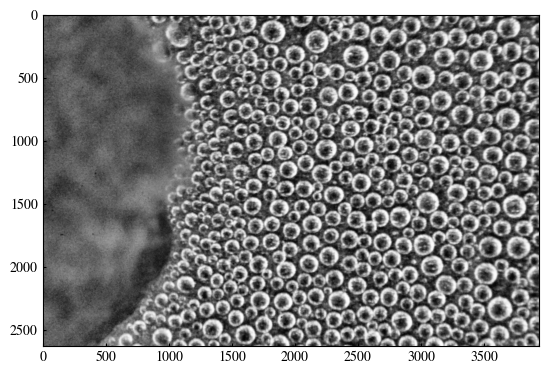

In [13]:
plt.imshow(blurred_frame, cmap='gray')

### 1.2 Detect edge

#### 1.2.1 Use gradient directly

In [145]:
# Compute image gradients (Sobel)
grad_x = cv2.Sobel(blurred_frame, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(blurred_frame, cv2.CV_64F, 0, 1, ksize=3)

# smooth the gradient images
grad_x = cv2.GaussianBlur(grad_x, (21, 21), 0)
grad_y = cv2.GaussianBlur(grad_y, (21, 21), 0)

# Compute gradient magnitude and direction
magnitude = np.sqrt(grad_x**2 + grad_y**2)
direction = np.arctan2(grad_y, grad_x) + np.pi

# Normalize magnitude
magnitude /= (magnitude.max() + 1e-5)

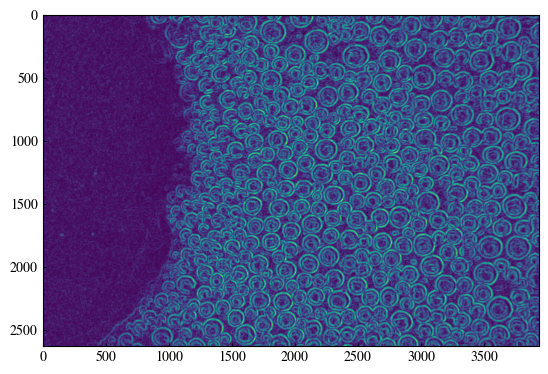

In [52]:
plt.imshow(magnitude)

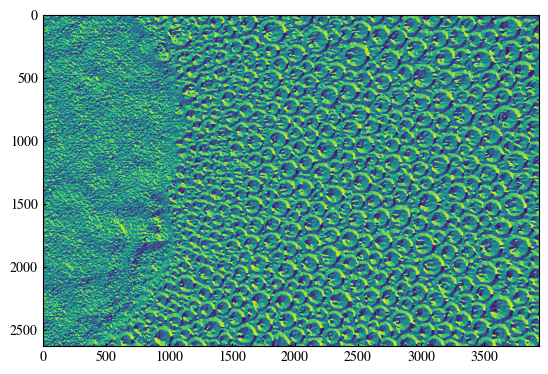

In [53]:
plt.imshow(direction)

#### 1.2.2 Canny edge

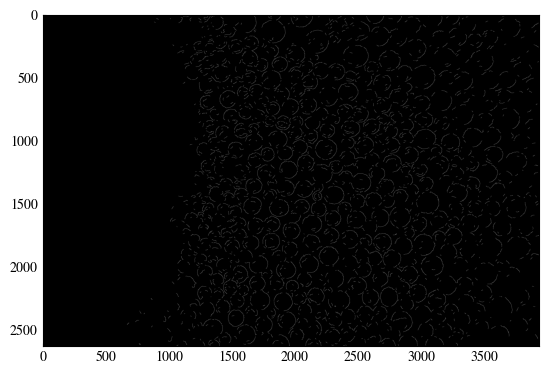

In [137]:
magnitude = cv2.Canny(blurred_frame, 100, 150)
plt.imshow(magnitude, cmap='gray')

In [138]:
s = 21
grad_x = cv2.Sobel(magnitude, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(magnitude, cv2.CV_64F, 0, 1, ksize=3)
grad_x = cv2.GaussianBlur(grad_x, (s, s), 0)
grad_y = cv2.GaussianBlur(grad_y, (s, s), 0)
direction = np.arctan2(grad_y, grad_x) + np.pi

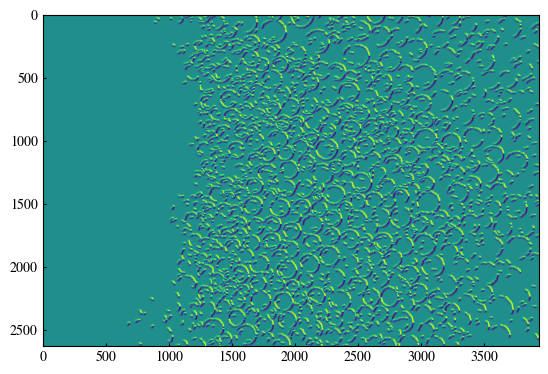

In [139]:
plt.imshow(direction)

### 1.3 Construct accumulator

In [146]:
# Thresholding for strong edges
strong_edges = magnitude > magnitude.mean()

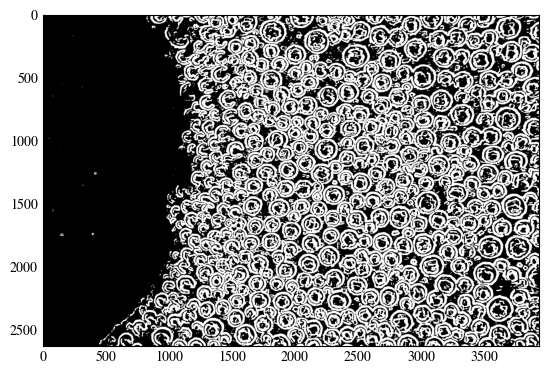

In [151]:
plt.imshow(strong_edges, cmap='gray')

In [147]:
# Create accumulator using vectorized voting
height, width = gray.shape
accumulator = np.zeros_like(gray, dtype=np.float32)

# Get indices of strong edge points
y_idx, x_idx = np.where(strong_edges)
theta = direction[y_idx, x_idx]

In [148]:
# Precompute cosine and sine values for efficiency
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)

In [149]:
# Loop through radius values, updating accumulator
min_radius, max_radius = 50, 60
for r in range(min_radius, max_radius, 2):  # Step size of 5 for performance
    x_shift = (r * cos_theta).astype(np.int32)
    y_shift = (r * sin_theta).astype(np.int32)
    xc = x_idx - x_shift
    yc = y_idx - y_shift

    # Validity check
    valid = (xc >= 0) & (xc < width) & (yc >= 0) & (yc < height)
    accumulator[yc[valid], xc[valid]] += magnitude[y_idx[valid], x_idx[valid]]

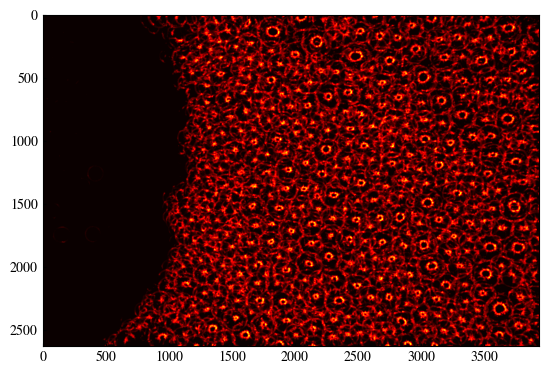

In [150]:
plt.imshow(accumulator, cmap='hot')

In [111]:
# Apply Gaussian smoothing
accumulator_smooth = gaussian_filter(accumulator, sigma=(min_radius//10)*2+1)

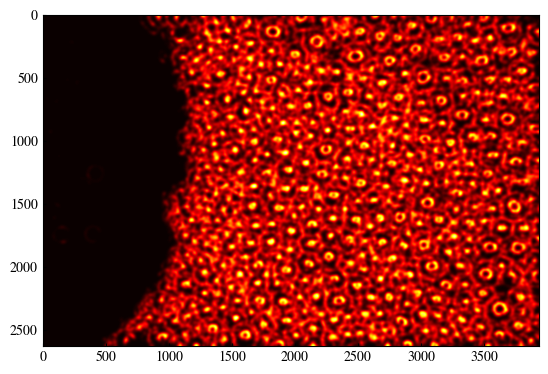

In [112]:
plt.imshow(accumulator_smooth, cmap='hot')

### 1.4 Find peaks in accumulator

In [113]:
# Find local maxima
centers = peak_local_max(accumulator_smooth, min_distance=min_radius, threshold_abs=0.1)

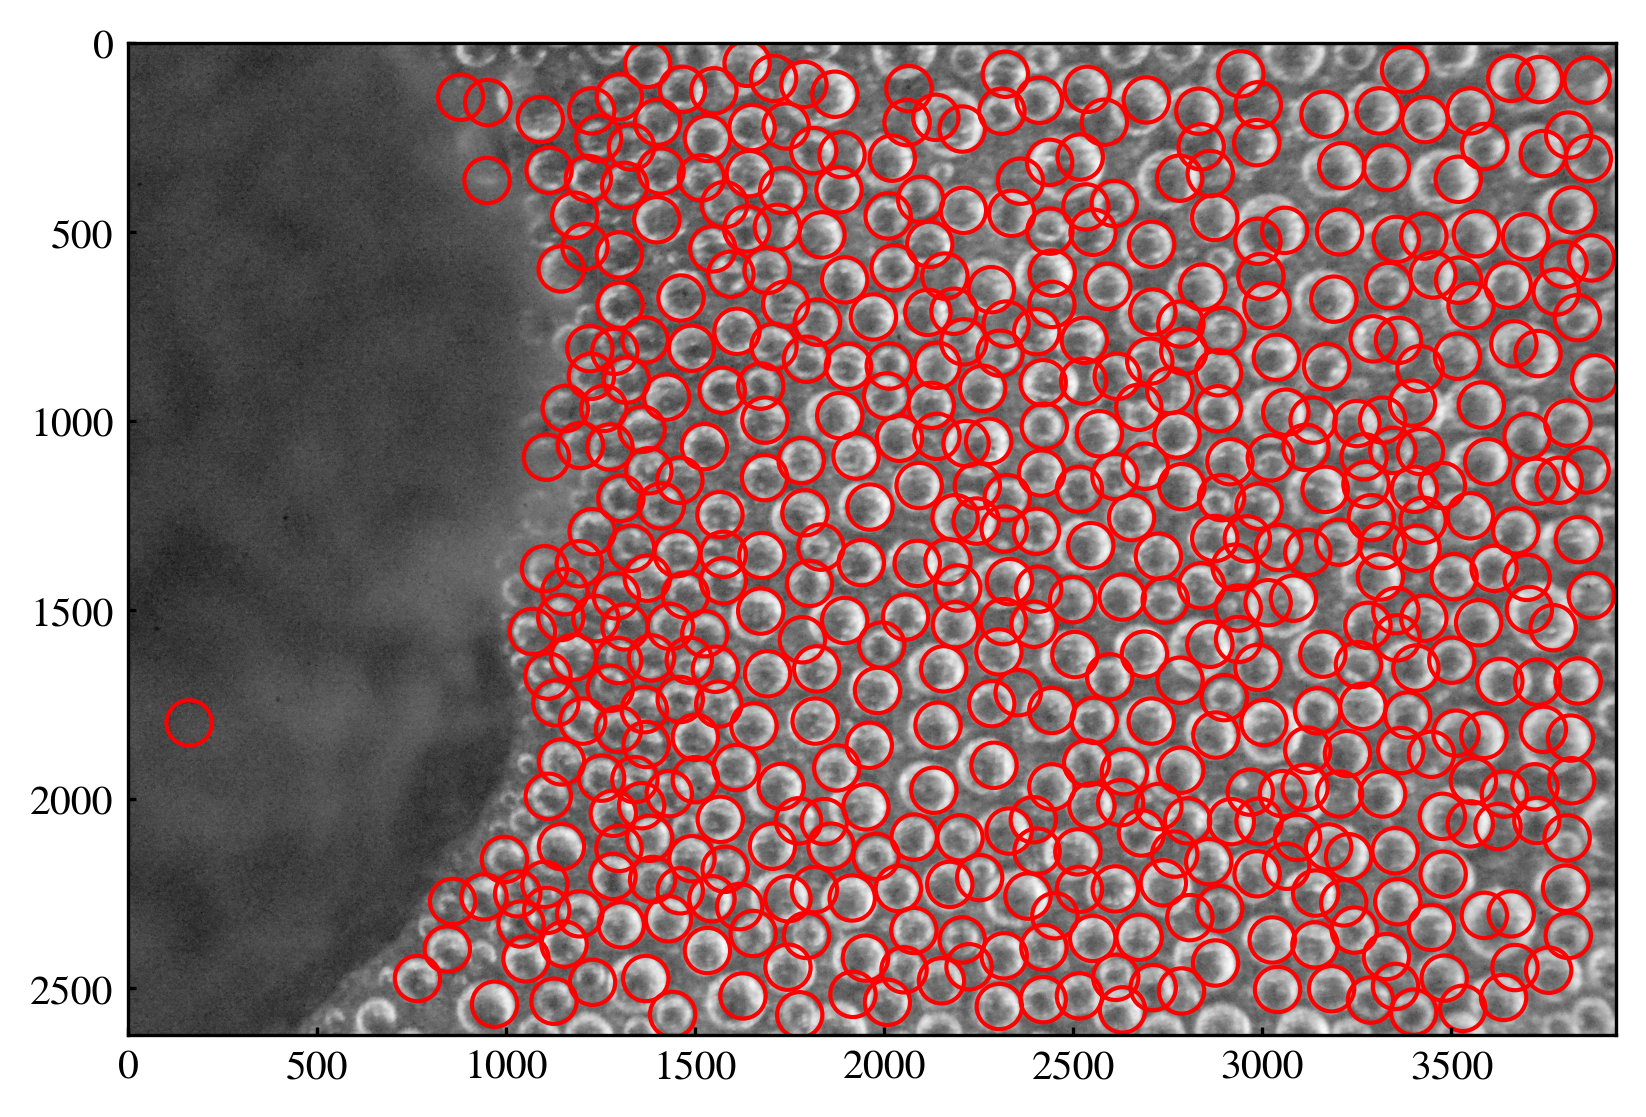

In [114]:
plt.figure(dpi=300)
plt.imshow(gray, cmap='gray')
for (x, y) in centers:
    circ = plt.Circle((y, x), 60, color='r', fill=False)
    plt.gca().add_patch(circ)

### 1.5 Estimate radii

In [115]:
score_thres = magnitude[strong_edges].max()
sensitivity = .9

In [116]:
# Estimate radii
radii = []
angles = np.linspace(0, 2*np.pi, 50) # 8 angles
for y, x in centers:
    radius_votes = []
    scores = []
    for r in range(min_radius, max_radius, 1):
        dx, dy = (r * np.cos(angles)).astype(int), (r * np.sin(angles)).astype(int)
        if (0 <= x + dx).all() and (x + dx < width).all() \
            and (0 <= y + dy).all and (y + dy < height).all(): # validity check
            score = magnitude[y + dy, x + dx].mean() 
            if score > (1-sensitivity) * score_thres: # if shifted point is strong edge
                radius_votes.append(r)
                scores.append(score)
    if scores:
        best_radius = radius_votes[np.argmax(scores)]
        radii.append(best_radius)
    else:
        radii.append(0)

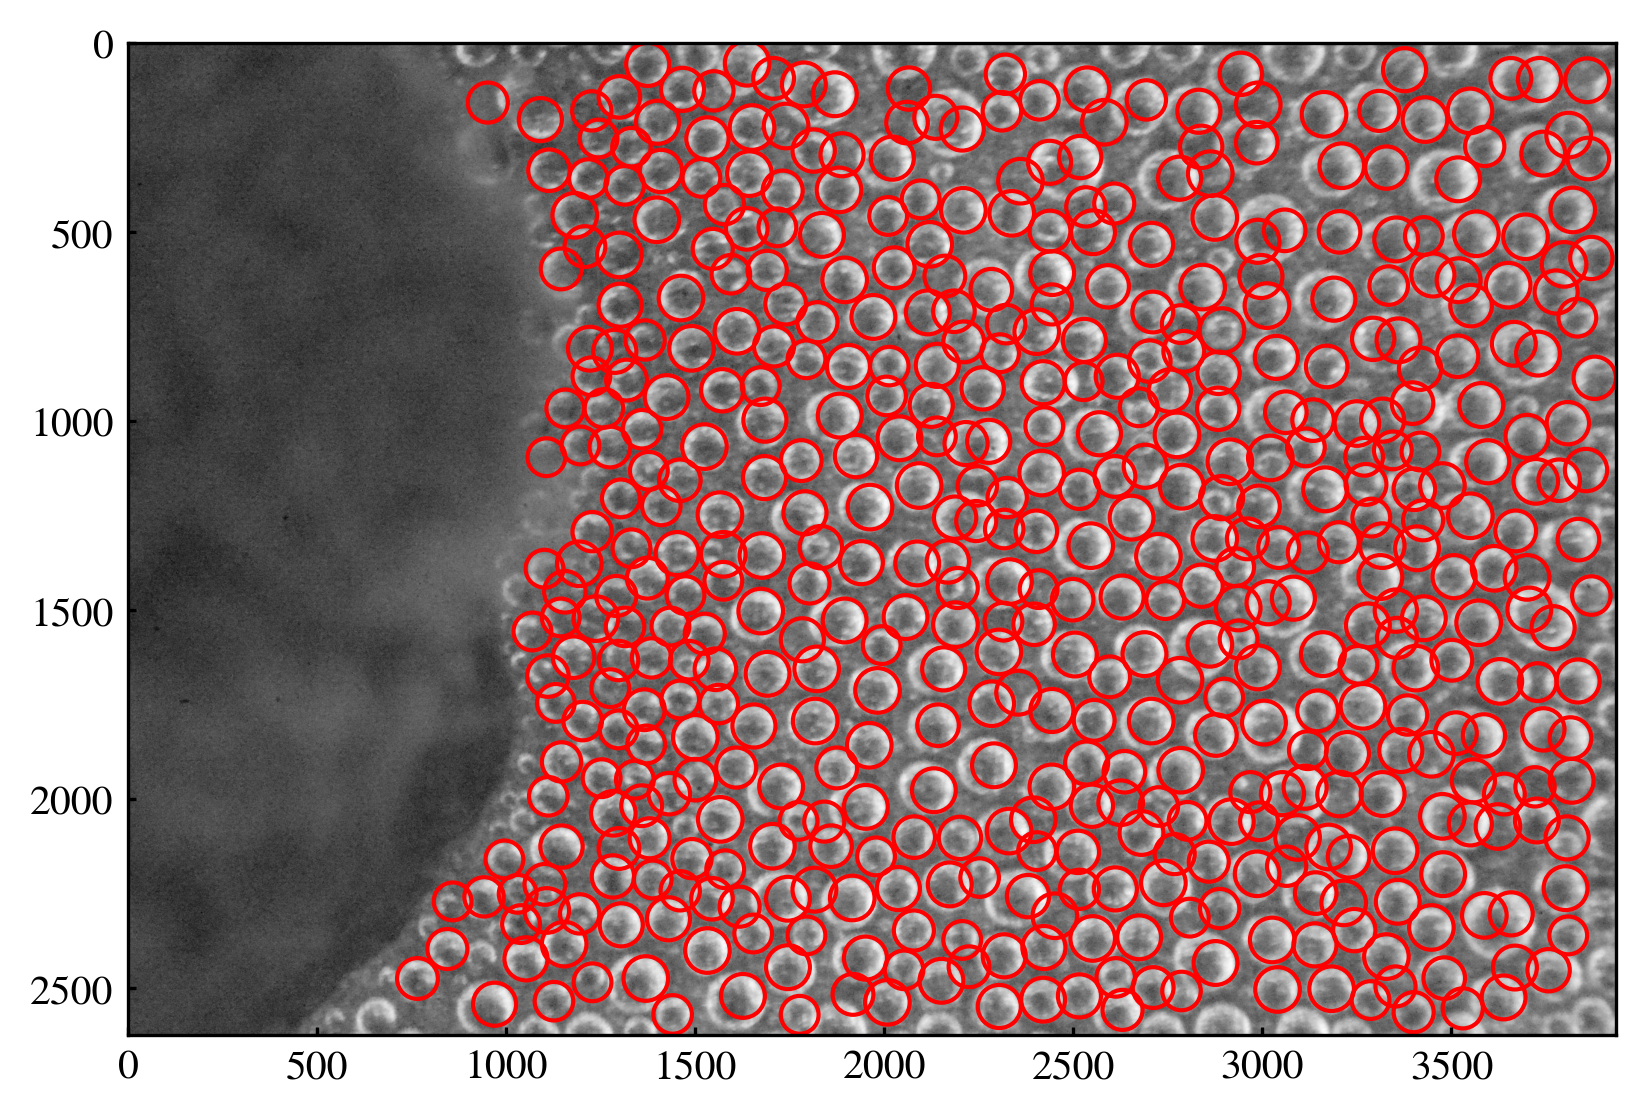

In [117]:
# Visualize results
fig, ax = plt.subplots(dpi=300)
ax.imshow(gray, cmap='gray')
for (y, x), r in zip(centers, radii):
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=1)
    ax.add_patch(circle)
plt.show()

## 2 Combine the steps

Let's now combine all the 5 steps in a function. First, let's plan the parameters. 

A very important parameter is the **initial smoothing size**, which I believe should be considered as preprocessing. However, to simplify the use of the function, it is desired that we minimize the number of lines. So, I'm going to include the smoothing to the function, and provide an optional argument for the smoothing window size.  

For the edge detection, let's fix the gradient kernel to 3, i.e. do not allow user to adjust it. 

We need to determine a threshold for strong edge. Only the strong edges will be used to construct the accumulator. Later in step 5, the strong edges will also be used to determine a threshold for edge brightness. Here, tentatively, we fix the threshold for strong edge as the mean of the magnitude map. 

To construct the accumulator, `min_radius` and `max_radius` are needed. They are given in a 2-array.

The accumulator is smoothed with a Gaussian filter, whose size is determined as `(min_radius//10)*2+1`.

`peak_local_max` has two optional arguments: `min_distance` and `threshold_abs`. We determine the `min_distance` as the `min_radius`, as the actual minimum distance used is `2*min_dist+1`. We also fix `threshold_abs` at 0.1, as the result is not very sensitive to it. 

Lastly, we choose to implement a `sensitivity` parameter, which determines how bright of a pixel that would consider it as an edge during the radius voting process. The sensitivity takes values in (0, 1], and higher value leads to more detected circle.

The results will be given as a DataFrame of x,y,r. `r=0` entries will be trimmed. 

In [ ]:
def imfindcircles_new(img, radius, smooth_window=11, sensitivity=0.85):
    """
    Find circles in images. The algorithm is based on Hough Transform and the idea of `Atherton and Kerbyson 1999 <https://www.sciencedirect.com/science/article/pii/S0262885698001607>`_, using the edge orientation information to improve the performance on noisy images. See `step-by-step phase code find circles <../tests/find_circles.html>`_ for more details about this method.

    :param img: Input image. Note that it has to be grayscale and 8-bit, otherwise the function will raise an error.
    :type img: numpy array
    :param radius: Radius of circles to detect. A list of 2 values, [minimum, maximum].
    :type radius: list
    :param sensitivity: Sensitivity for circle detection. The sensitivity takes values in (0, 1], and higher value leads to more detected circle.
    :type sensitivity: float
    :return: DataFrame with columns [x, y, r] for the centers and radii of detected circles.
    :rtype: pandas.DataFrame

    >>> from myimagelib import imfindcircles
    >>> circles = imfindcircles(img, [10, 20])
    >>> circles = imfindcircles(img, [10, 20], smooth_window=5)
    >>> circles = imfindcircles(img, [10, 20], smooth_window=5, sensitivity=0.9)

    .. rubric:: Edit
    
    * Feb 27, 2025 -- Initial commit.
    * Feb 28, 2025 -- (i) Add `smooth_window` argument, include the preprocessing step in this function to simplify the code on the user side; (ii) determine step size adaptively.
    * Mar 04, 2025 -- (i) Use Canny edge detector
    """
    assert(img.ndim == 2), "Input image must be grayscale"
    assert(img.dtype == np.uint8), "Input image must be 8-bit"

    s = smooth_window // 2 * 2 + 1 # make sure the window size is odd

    # preprocess the image
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))
    # img = clahe.apply(img)
    img = cv2.GaussianBlur(img, (s, s), 0)

    # Compute gradient magnitude and direction
    magnitude = cv2.Canny(img, 0, 180)
    grad_x = cv2.Sobel(magnitude, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(magnitude, cv2.CV_64F, 0, 1, ksize=3)
    grad_x = cv2.GaussianBlur(grad_x, (s, s), 0)
    grad_y = cv2.GaussianBlur(grad_y, (s, s), 0)
    direction = np.arctan2(grad_y, grad_x) + np.pi

    # Thresholding for strong edges
    strong_edges = magnitude > magnitude.mean()

    # Create accumulator using vectorized voting
    height, width = img.shape
    accumulator = np.zeros_like(img, dtype=np.float32)
    # Get indices of strong edge points
    y_idx, x_idx = np.where(strong_edges)
    theta = direction[y_idx, x_idx]
    # Precompute cosine and sine values for efficiency
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    # Loop through radius values, updating accumulator
    min_radius, max_radius = radius
    for r in range(min_radius, max_radius, 5):  # Step size of 5 for performance
        x_shift = (r * cos_theta).astype(np.int32)
        y_shift = (r * sin_theta).astype(np.int32)
        xc = x_idx - x_shift
        yc = y_idx - y_shift
        # Validity check
        valid = (xc >= 0) & (xc < width) & (yc >= 0) & (yc < height)
        accumulator[yc[valid], xc[valid]] += magnitude[y_idx[valid], x_idx[valid]]

    # Apply Gaussian smoothing to accumulator
    accumulator_smooth = gaussian_filter(accumulator, sigma=(min_radius//10)*2+1)
    # Find local maxima
    centers = peak_local_max(accumulator_smooth, min_distance=min_radius, threshold_abs=0.1)
    
    # Estimate radii
    score_thres = magnitude[strong_edges].max()

    radii = []
    angles = np.linspace(0, 2*np.pi, 8) # 8 angles
    for y, x in centers:
        radius_votes = []
        scores = []
        for r in range(min_radius, max_radius, 1):
            dx, dy = (r * np.cos(angles)).astype(int), (r * np.sin(angles)).astype(int)
            if (0 <= x + dx).all() and (x + dx < width).all() \
                and (0 <= y + dy).all and (y + dy < height).all(): # validity check
                score = magnitude[y + dy, x + dx].mean() 
                if score > (1-sensitivity) * score_thres: # if shifted point is strong edge
                    radius_votes.append(r)
                    scores.append(score)
        if scores:
            best_radius = radius_votes[np.argmax(scores)]
            radii.append(best_radius)
        else:
            radii.append(0)

    # construct the dataframe for centers and radii
    df = pd.DataFrame(centers, columns=["y", "x"])
    df["r"] = radii

    # keep only the circles with radius > 0
    df = df[df["r"] > 0]

    return df

In [ ]:
df = imfindcircles_new(enhanced_gray, [50, 60], sensitivity=0.9, smooth_window=21)

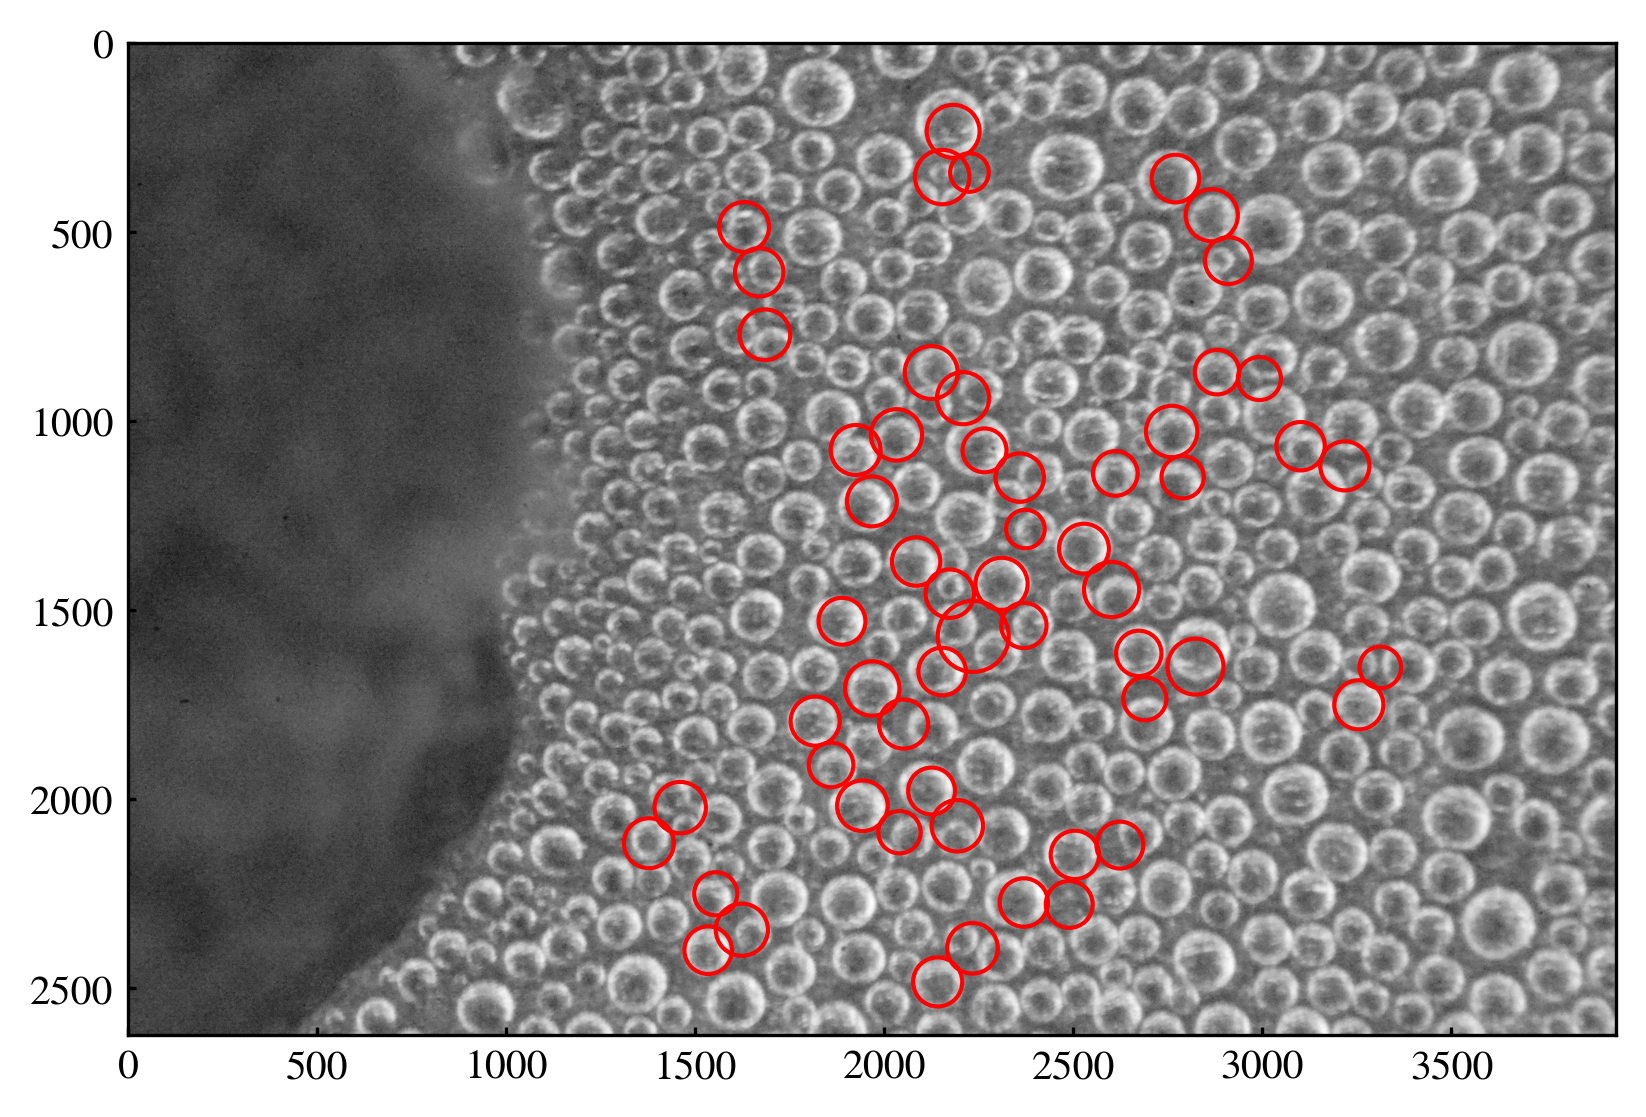

In [9]:
plt.figure(dpi=300)
plt.imshow(gray, cmap='gray')
for _, row in df.iterrows():
    circ = plt.Circle((row["x"], row["y"]), row["r"], color='r', fill=False)
    plt.gca().add_patch(circ)

## 3 Development

This section compares the newly developed algorithm with existing algorithm in `myImageLib`. 

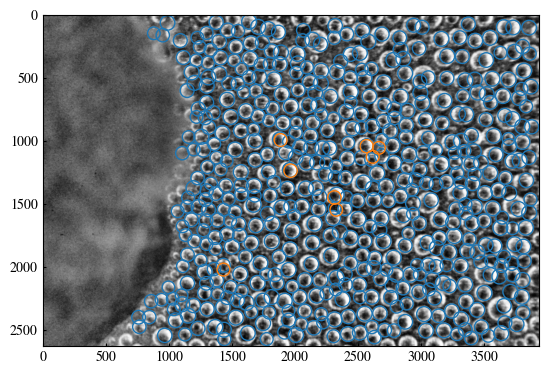

In [128]:
radii = [50, 60]
sensitivity = 0.9
smooth_window = 21
img = blurred_frame
plt.imshow(img, cmap='gray')
df_new = imfindcircles_new(img, radii, sensitivity=sensitivity, smooth_window=smooth_window)
df = imfindcircles(img, radii, sensitivity=sensitivity, smooth_window=smooth_window)
for _, row in df.iterrows():
    circ = plt.Circle((row["x"], row["y"]), row["r"], color=bestcolor(0), fill=False, lw=1)
    plt.gca().add_patch(circ)
for _, row in df_new.iterrows():
    circ = plt.Circle((row["x"], row["y"]), row["r"], color=bestcolor(1), fill=False, lw=1)
    plt.gca().add_patch(circ)